In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch.nn as nn
import torch.nn.functional as F

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device, device.type)

#get training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


cuda cuda
Files already downloaded and verified
Files already downloaded and verified


In [2]:
%%bash
nvidia-smi

Thu Dec  5 01:25:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:07:00.0 Off |                    0 |
| N/A   36C    P0             62W /  400W |       4MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

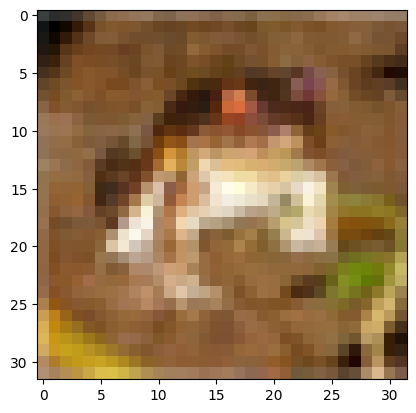

In [3]:
#display the first image in the training set
image, label = trainset[0]
plt.imshow(image.permute(1,2,0))

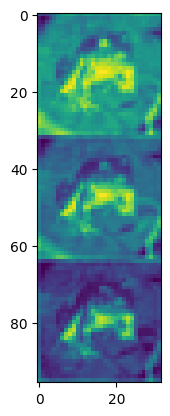

In [4]:
#tensor = torchvision.transforms.ToTensor()(image)
tensor = image
#display tensor red channel
plt.imshow(tensor[0,...].numpy())
#display tensor green channel
plt.imshow(tensor[1,...].numpy())
#display tensor blue channel
plt.imshow(tensor[2,...].numpy())
#display all in the same window
plt.imshow(torch.cat((tensor[0,...], tensor[1,...], tensor[2,...]), 0).numpy())

In [5]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4)
dataiter = iter(train_loader)
images, labels = next(dataiter)
#print(images, labels)


In [6]:
class FirstModel(nn.Module):
    def __init__(self, n_out1=512, n_out2=256):
        super().__init__()
        
        self.a = nn.Linear(3 * 32 * 32, n_out1)
        self.b = nn.Linear(n_out1, n_out2)
        self.c = nn.Linear(n_out2, 10)

    def forward(self, x):
        x = self.a(x)
        x = self.b(x)
        return F.softmax(self.c(x), dim=1)

In [7]:

batch = next(iter(train_loader))
print(batch[0].shape)
fc = nn.Linear(3*32*32,10)
output = fc(batch[0].view(-1, 3*32*32))
print(output.shape)
output = fc(torch.reshape(batch[0], (-1, 3*32*32)))
print(output)
#output = fc(batch[0].resize_(3*32*32))
#print(output.shape)
reshaped_batch = torch.reshape(batch[0], (-1, 3*32*32))
print(reshaped_batch)


torch.Size([4, 3, 32, 32])
torch.Size([4, 10])
tensor([[ 0.2889,  0.1607, -0.1846,  0.2251, -0.5833, -0.0284,  0.0359,  0.5488,
         -0.4064, -0.1609],
        [ 0.3462, -0.0180, -0.1394,  0.3504, -0.3437,  0.0861,  0.0106,  0.3049,
         -0.0100, -0.3418],
        [ 0.2022, -0.2066, -0.0654,  0.7413, -0.2176,  0.2403,  0.0947,  0.7635,
          0.0743, -0.0914],
        [ 0.2053,  0.1213, -0.0638,  0.2080, -0.3656, -0.1023, -0.0020,  0.4149,
         -0.3494, -0.1352]], grad_fn=<AddmmBackward0>)
tensor([[0.2314, 0.1686, 0.1961,  ..., 0.5490, 0.3294, 0.2824],
        [0.6039, 0.4941, 0.4118,  ..., 0.5451, 0.5569, 0.5647],
        [1.0000, 0.9922, 0.9922,  ..., 0.3255, 0.3255, 0.3294],
        [0.1098, 0.1451, 0.1490,  ..., 0.1098, 0.1451, 0.1804]])


In [8]:
torch.set_printoptions(threshold=1000)
b = torch.permute(batch[0], (0,2,3,1))
print(b.shape)
model = FirstModel()
probs = model(reshaped_batch)
print(probs.shape)
print(probs)
images, labels = torch.max(probs, dim=1)
print(f"images ({images.shape}):", images.data)
print(f"labels({labels.shape}):", labels)
#batch.permute(0,2,3,1) à utiliser plus tard


torch.Size([4, 32, 32, 3])
torch.Size([4, 10])
tensor([[0.1014, 0.0989, 0.0857, 0.0945, 0.0958, 0.1001, 0.1068, 0.0954, 0.1257,
         0.0957],
        [0.1006, 0.0973, 0.0884, 0.0967, 0.0976, 0.0947, 0.1178, 0.0911, 0.1262,
         0.0896],
        [0.0944, 0.0961, 0.0989, 0.0999, 0.0969, 0.1038, 0.0957, 0.1036, 0.1171,
         0.0935],
        [0.1021, 0.0995, 0.0908, 0.0982, 0.0905, 0.1032, 0.1123, 0.0926, 0.1190,
         0.0918]], grad_fn=<SoftmaxBackward0>)
images (torch.Size([4])): tensor([0.1257, 0.1262, 0.1171, 0.1190])
labels(torch.Size([4])): tensor([8, 8, 8, 8])


In [9]:
def prediction_accuracy(model, data, device, flatten=True):
    correct = 0
    total = 0
    if device.type == "cuda":
        model = model.to(device)
    for image, label in data:
        image, label = image.to(device), label.to(device)
        
        if flatten:
            image = torch.reshape(image, (-1, 3*32*32))  
        
        output = model(image)
        _, pred_label = torch.max(output, dim=1)
        
        # Update total and correct counts
        total += label.size(0)
        correct += (pred_label == label).sum().item()
    
    accuracy = correct / total
    print(f'Correct: {correct}, Total: {total}, Accuracy: {accuracy:.2f}')
    return accuracy


In [10]:
test_model = FirstModel()
acc = prediction_accuracy(test_model, test_loader, device)
#print accuracy as percentage
print(f"accuracy: {acc * 100}% ({acc})")

Correct: 935, Total: 10000, Accuracy: 0.09
accuracy: 9.35% (0.0935)


In [11]:
learning_rate = 0.001
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
from tqdm import tqdm
def fit_one_cycle(model, optimizer, eindex, writer, device, flatten=True, size=None, log_freq=20):
    running_loss = 0.0
    last_loss = 0.0
    i = 0
    
    data = train_loader
    if size is not None:
        print(f"Truncating dataset to {size} samples")
        data = []
        for batch in train_loader:
            if len(data) == size:
                break
            data.append(batch)
            
    num_batches = len(train_loader)
    log_interval = max(1, num_batches // log_freq)

    model.train(True)  # Set the model to training mode
    
    for image, label in tqdm(data, desc="Training", leave=True):
        optimizer.zero_grad()
        
        image, label = image.to(device), label.to(device)
        
        if flatten:
            image = torch.reshape(image, (-1, 3*32*32))
        
        output = model(image)
        
        probs = output.float()

        loss = F.cross_entropy(probs, label)
                
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % log_interval == (log_interval - 1):
            last_loss = running_loss / log_interval
            #print(print('  batch {} loss: {}'.format(i + 1, last_loss)))
            tb_x = eindex * len(train_loader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0
        i += 1

    return last_loss
        

In [13]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [14]:
test_model = FirstModel()
learning_rate = 0.01
opt = torch.optim.SGD(test_model.parameters(), lr=learning_rate)
if device.type == "cuda":
    test_model = test_model.to(device) 
fit_one_cycle(test_model, opt, 0, writer, device)
acc = prediction_accuracy(test_model, test_loader, device)

#print accuracy as percentage
print(f"accuracy: {acc * 100}% ({acc})")

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 849.50it/s]


Correct: 3398, Total: 10000, Accuracy: 0.34
accuracy: 33.98% (0.3398)


In [15]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [16]:
test_model = FirstModel()
learning_rate = 0.001
opt = torch.optim.SGD(test_model.parameters(), lr=learning_rate)
epochs = 10
if device.type == "cuda":
    test_model = test_model.to(device)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    fit_one_cycle(test_model, opt, epoch, writer, device)
    acc = prediction_accuracy(test_model, test_loader, device)
    print(f"accuracy: {acc * 100}% ({acc})")

Epoch 1


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 861.10it/s]


Correct: 1434, Total: 10000, Accuracy: 0.14
accuracy: 14.34% (0.1434)
Epoch 2


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 861.47it/s]


Correct: 2326, Total: 10000, Accuracy: 0.23
accuracy: 23.26% (0.2326)
Epoch 3


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 865.84it/s]


Correct: 2739, Total: 10000, Accuracy: 0.27
accuracy: 27.389999999999997% (0.2739)
Epoch 4


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 888.58it/s]


Correct: 2921, Total: 10000, Accuracy: 0.29
accuracy: 29.21% (0.2921)
Epoch 5


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 890.61it/s]


Correct: 3010, Total: 10000, Accuracy: 0.30
accuracy: 30.099999999999998% (0.301)
Epoch 6


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 890.77it/s]


Correct: 3096, Total: 10000, Accuracy: 0.31
accuracy: 30.959999999999997% (0.3096)
Epoch 7


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 893.67it/s]


Correct: 3199, Total: 10000, Accuracy: 0.32
accuracy: 31.990000000000002% (0.3199)
Epoch 8


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 893.35it/s]


Correct: 3257, Total: 10000, Accuracy: 0.33
accuracy: 32.57% (0.3257)
Epoch 9


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 893.35it/s]


Correct: 3387, Total: 10000, Accuracy: 0.34
accuracy: 33.87% (0.3387)
Epoch 10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 893.68it/s]


Correct: 3438, Total: 10000, Accuracy: 0.34
accuracy: 34.38% (0.3438)


In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [18]:
def validation_loop(model, data, epochs, writer, device, flatten=True):
    best_vloss = 1_000_000.
    
    if device.type == "cuda":
        model = model.to(device)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        
        model.train(True)
        avg_loss = fit_one_cycle(model, opt, epoch, writer, device, flatten)
        i = 0
        
        running_vloss = 0.0
        model.eval()
        
        with torch.no_grad():
            for validation_data in tqdm(data, desc="Validation", leave=True):
                vimages, vlabels = validation_data
                vimages, vlabels = vimages.to(device), vlabels.to(device)
                
                if flatten:
                    vimages = torch.reshape(vimages, (-1, 3*32*32))
                
                validation_output = model(vimages)
                validation_loss = F.cross_entropy(validation_output, vlabels)
                running_vloss += validation_loss
                
                i += 1
        
        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch + 1)
        
        writer.flush()
        
        if avg_loss < best_vloss:
            best_vloss = avg_loss
            print("Saving model")
            model_path = 'saved_models/model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

In [19]:
validation_loop(test_model, test_loader, epochs, writer, device)

Epoch 1


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1485.59it/s]


LOSS train 2.109196803665161 valid 2.1096315383911133
Saving model
Epoch 2


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1536.28it/s]


LOSS train 2.103691316986084 valid 2.104830026626587
Saving model
Epoch 3


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1540.27it/s]


LOSS train 2.099028208351135 valid 2.1009552478790283
Saving model
Epoch 4


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1537.57it/s]


LOSS train 2.095013786125183 valid 2.0971179008483887
Saving model
Epoch 5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1540.46it/s]


LOSS train 2.0913539779663086 valid 2.093435764312744
Saving model
Epoch 6


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1539.46it/s]


LOSS train 2.088191164970398 valid 2.090099811553955
Saving model
Epoch 7


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1541.12it/s]


LOSS train 2.085462055015564 valid 2.086949110031128
Saving model
Epoch 8


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1540.60it/s]


LOSS train 2.082991240119934 valid 2.083977460861206
Saving model
Epoch 9


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1525.88it/s]


LOSS train 2.080634234046936 valid 2.0812056064605713
Saving model
Epoch 10


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1541.51it/s]

LOSS train 2.0784282012939452 valid 2.0785603523254395
Saving model


In [20]:
class SecondModel(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        
        self.a = nn.Linear(3 * 32 * 32, hidden_dim)
        self.b = nn.Linear(hidden_dim, hidden_dim)
        self.c = nn.Linear(hidden_dim, hidden_dim)
        self.d = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = self.a(x)
        x = self.b(x)
        x = self.c(x)
        return F.softmax(self.d(x), dim=1)

In [21]:
model = SecondModel()
learning_rate = 0.001

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [23]:
validation_loop(model, train_loader, 10, writer, device)

Epoch 1


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.59it/s]


LOSS train 2.134559380380731 valid 2.109485149383545
Saving model
Epoch 2


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.65it/s]


LOSS train 2.1227895711597644 valid 2.0854201316833496
Saving model
Epoch 3


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.57it/s]


LOSS train 2.112787698444567 valid 2.0775744915008545
Saving model
Epoch 4


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.69it/s]


LOSS train 2.0873474949284603 valid 2.064000368118286
Saving model
Epoch 5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.83it/s]


LOSS train 2.0843811788057027 valid 2.063112497329712
Saving model
Epoch 6


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.70it/s]


LOSS train 2.0937465241080835 valid 2.053483247756958
Epoch 7


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.46it/s]


LOSS train 2.084443544086657 valid 2.061173915863037
Epoch 8


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.72it/s]


LOSS train 2.081404836554276 valid 2.0650687217712402
Saving model
Epoch 9


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.71it/s]


LOSS train 2.0812306027663383 valid 2.058511734008789
Saving model
Epoch 10


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.49it/s]

LOSS train 2.1027717339365104 valid 2.0441813468933105


In [24]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    fit_one_cycle(model, opt, epoch, writer, device)
    acc = prediction_accuracy(model, test_loader, device)
    print(f"accuracy: {acc * 100}% ({acc})")

Epoch 1


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.99it/s]


Correct: 3789, Total: 10000, Accuracy: 0.38
accuracy: 37.89% (0.3789)
Epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.19it/s]


Correct: 3847, Total: 10000, Accuracy: 0.38
accuracy: 38.47% (0.3847)
Epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.22it/s]


Correct: 3794, Total: 10000, Accuracy: 0.38
accuracy: 37.940000000000005% (0.3794)
Epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.21it/s]


Correct: 3669, Total: 10000, Accuracy: 0.37
accuracy: 36.69% (0.3669)
Epoch 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.18it/s]


Correct: 3833, Total: 10000, Accuracy: 0.38
accuracy: 38.33% (0.3833)
Epoch 6


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.17it/s]


Correct: 3887, Total: 10000, Accuracy: 0.39
accuracy: 38.87% (0.3887)
Epoch 7


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.10it/s]


Correct: 3880, Total: 10000, Accuracy: 0.39
accuracy: 38.800000000000004% (0.388)
Epoch 8


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.00it/s]


Correct: 3895, Total: 10000, Accuracy: 0.39
accuracy: 38.95% (0.3895)
Epoch 9


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.10it/s]


Correct: 3842, Total: 10000, Accuracy: 0.38
accuracy: 38.42% (0.3842)
Epoch 10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.07it/s]


Correct: 3697, Total: 10000, Accuracy: 0.37
accuracy: 36.97% (0.3697)


In [25]:
prediction_accuracy(model, test_loader, device)

Correct: 3697, Total: 10000, Accuracy: 0.37


0.3697

In [26]:
class ConvolutionalModel(nn.Module):
    def __init__(self, stride):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 3, stride=stride)
        self.conv2 = nn.Conv2d(6, 16, 3, stride=stride)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=stride)
        self.mlp = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        x = self.pool(x)
        
        x = F.gelu(self.conv2(x))
        x = self.pool(x)
        
        x = F.gelu(self.conv3(x))
        
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        
        return F.softmax(x, dim=1)

In [27]:
conv_model = ConvolutionalModel(stride=1)
if device.type == "cuda":
    conv_model = conv_model.to(device)
print(conv_model, opt, device)

learning_rate = 0.001

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)
opt = torch.optim.Adam(conv_model.parameters(), lr=learning_rate)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

epochs = 15
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    avg_loss = fit_one_cycle(conv_model, opt, epoch, writer, device, flatten=False)
    acc = prediction_accuracy(conv_model, test_loader, device, flatten=False)
    print(f"Accuracy: {acc * 100}% ({acc})\nLoss: {avg_loss}")

ConvolutionalModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (mlp): Linear(in_features=512, out_features=10, bias=True)
) Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) cuda
Epoch 1


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 65.24it/s]


Correct: 3391, Total: 10000, Accuracy: 0.34
Accuracy: 33.910000000000004% (0.3391)
Loss: 2.1450329705288538
Epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.43it/s]


Correct: 3849, Total: 10000, Accuracy: 0.38
Accuracy: 38.49% (0.3849)
Loss: 2.081033832148502
Epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.33it/s]


Correct: 4150, Total: 10000, Accuracy: 0.41
Accuracy: 41.5% (0.415)
Loss: 2.0354411225569877
Epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.11it/s]


Correct: 4366, Total: 10000, Accuracy: 0.44
Accuracy: 43.66% (0.4366)
Loss: 2.040410305324354
Epoch 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.38it/s]


Correct: 4473, Total: 10000, Accuracy: 0.45
Accuracy: 44.73% (0.4473)
Loss: 2.0138502811130725
Epoch 6


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.67it/s]


Correct: 4565, Total: 10000, Accuracy: 0.46
Accuracy: 45.65% (0.4565)
Loss: 1.985540747642517
Epoch 7


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.24it/s]


Correct: 4721, Total: 10000, Accuracy: 0.47
Accuracy: 47.21% (0.4721)
Loss: 1.9698506970154612
Epoch 8


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.59it/s]


Correct: 4785, Total: 10000, Accuracy: 0.48
Accuracy: 47.85% (0.4785)
Loss: 1.9740371955068488
Epoch 9


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.83it/s]


Correct: 4810, Total: 10000, Accuracy: 0.48
Accuracy: 48.1% (0.481)
Loss: 1.9763091363404925
Epoch 10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.86it/s]


Correct: 4777, Total: 10000, Accuracy: 0.48
Accuracy: 47.77% (0.4777)
Loss: 1.9481620474865562
Epoch 11


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.92it/s]


Correct: 4959, Total: 10000, Accuracy: 0.50
Accuracy: 49.59% (0.4959)
Loss: 1.9434230327606201
Epoch 12


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.93it/s]


Correct: 5009, Total: 10000, Accuracy: 0.50
Accuracy: 50.09% (0.5009)
Loss: 1.9308840287359137
Epoch 13


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.99it/s]


Correct: 5123, Total: 10000, Accuracy: 0.51
Accuracy: 51.23% (0.5123)
Loss: 1.940484787288465
Epoch 14


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.93it/s]


Correct: 5109, Total: 10000, Accuracy: 0.51
Accuracy: 51.09% (0.5109)
Loss: 1.9144225057802702
Epoch 15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.84it/s]


Correct: 5022, Total: 10000, Accuracy: 0.50
Accuracy: 50.22% (0.5022)
Loss: 1.9222495932328074


In [28]:
validation_loop(conv_model, train_loader, epochs, writer, device, flatten=False)

Epoch 1


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.25it/s]


LOSS train 1.9033755816911395 valid 1.90347421169281
Saving model
Epoch 2


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.42it/s]


LOSS train 1.9116562542162443 valid 1.9050859212875366
Epoch 3


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.47it/s]


LOSS train 1.9117108144258197 valid 1.891832709312439
Epoch 4


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.38it/s]


LOSS train 1.8957085609436035 valid 1.9010725021362305
Saving model
Epoch 5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.64it/s]


LOSS train 1.8849379702618247 valid 1.8791587352752686
Saving model
Epoch 6


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.15it/s]


LOSS train 1.8787798693305569 valid 1.8805879354476929
Saving model
Epoch 7


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.40it/s]


LOSS train 1.8947773607153642 valid 1.881413459777832
Epoch 8


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.90it/s]


LOSS train 1.9004598918714022 valid 1.8774312734603882
Epoch 9


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.67it/s]


LOSS train 1.8739274551993923 valid 1.8688076734542847
Saving model
Epoch 10


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.57it/s]


LOSS train 1.866797961686787 valid 1.8707298040390015
Saving model
Epoch 11


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.65it/s]


LOSS train 1.8749064646269147 valid 1.8627781867980957
Epoch 12


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.52it/s]


LOSS train 1.8780115403627093 valid 1.8668302297592163
Epoch 13


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.16it/s]


LOSS train 1.8809756856215627 valid 1.8577682971954346
Epoch 14


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.07it/s]


LOSS train 1.8796743468234414 valid 1.874685287475586
Epoch 15


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.20it/s]

LOSS train 1.873974229160108 valid 1.8460988998413086


In [29]:
class StridedConvolutionalModel(nn.Module):
    def __init__(self, stride):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, stride=stride)
        self.conv2 = nn.Conv2d(6, 16, 3, stride=stride)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1)
        self.mlp = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        x = F.gelu(self.conv1(x))
        
        x = F.gelu(self.conv2(x))
        
        x = F.gelu(self.conv3(x))
        
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        
        return F.softmax(x, dim=1)

In [30]:
class ResidualConvolutionalModel(nn.Module):
    def __init__(self, stride=1):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=stride, padding=1)
        self.mlp = nn.Linear(in_features=(32 * 8 * 8), out_features=10)

        self.proj1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=1, stride=stride)
        self.proj2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=1, stride=stride)
        self.proj3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=stride)

    def forward(self, x):
        res1 = self.proj1(x)
        x = F.gelu(self.conv1(x))
        x = x + res1
        x = self.pool(x)
        
        res2 = self.proj2(x)
        x = F.gelu(self.conv2(x))
        x = x + res2
        x = self.pool(x)
        
        res3 = self.proj3(x)
        x = F.gelu(self.conv3(x))
        x = x + res3
        
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        
        return F.softmax(x, dim=1)

In [31]:
conv_model = ResidualConvolutionalModel()
if device.type == "cuda":
    conv_model = conv_model.to(device)

learning_rate = 0.001

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

opt = torch.optim.Adam(conv_model.parameters(), lr=learning_rate)
print(conv_model, opt, device)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

epochs = 15
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    avg_loss = fit_one_cycle(conv_model, opt, epoch, writer, device, flatten=False)
    acc = prediction_accuracy(conv_model, test_loader, device, flatten=False)
    print(f"Accuracy: {acc * 100}% ({acc})\nLoss: {avg_loss}")

ResidualConvolutionalModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mlp): Linear(in_features=2048, out_features=10, bias=True)
  (proj1): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1))
  (proj2): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1))
  (proj3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
) Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) cuda
Epoch 1


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 69.16it/s]


Correct: 4309, Total: 10000, Accuracy: 0.43
Accuracy: 43.09% (0.4309)
Loss: 2.049777256815057
Epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 70.99it/s]


Correct: 4596, Total: 10000, Accuracy: 0.46
Accuracy: 45.96% (0.4596)
Loss: 2.011843486836082
Epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.72it/s]


Correct: 4795, Total: 10000, Accuracy: 0.48
Accuracy: 47.949999999999996% (0.4795)
Loss: 1.9950272974215055
Epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.49it/s]


Correct: 4942, Total: 10000, Accuracy: 0.49
Accuracy: 49.419999999999995% (0.4942)
Loss: 1.9490987627129805
Epoch 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.65it/s]


Correct: 5004, Total: 10000, Accuracy: 0.50
Accuracy: 50.03999999999999% (0.5004)
Loss: 1.9440561031040393
Epoch 6


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.61it/s]


Correct: 5139, Total: 10000, Accuracy: 0.51
Accuracy: 51.39% (0.5139)
Loss: 1.9336061916853253
Epoch 7


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.67it/s]


Correct: 5234, Total: 10000, Accuracy: 0.52
Accuracy: 52.339999999999996% (0.5234)
Loss: 1.9224098920822144
Epoch 8


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.48it/s]


Correct: 5328, Total: 10000, Accuracy: 0.53
Accuracy: 53.28000000000001% (0.5328)
Loss: 1.8990827987068577
Epoch 9


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.55it/s]


Correct: 5389, Total: 10000, Accuracy: 0.54
Accuracy: 53.89000000000001% (0.5389)
Loss: 1.9150423627150686
Epoch 10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.78it/s]


Correct: 5502, Total: 10000, Accuracy: 0.55
Accuracy: 55.02% (0.5502)
Loss: 1.8866726912950214
Epoch 11


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.76it/s]


Correct: 5579, Total: 10000, Accuracy: 0.56
Accuracy: 55.78999999999999% (0.5579)
Loss: 1.8794132973018445
Epoch 12


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.83it/s]


Correct: 5701, Total: 10000, Accuracy: 0.57
Accuracy: 57.010000000000005% (0.5701)
Loss: 1.8774762279108952
Epoch 13


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.59it/s]


Correct: 5725, Total: 10000, Accuracy: 0.57
Accuracy: 57.25% (0.5725)
Loss: 1.8627582725725675
Epoch 14


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.61it/s]


Correct: 5791, Total: 10000, Accuracy: 0.58
Accuracy: 57.91% (0.5791)
Loss: 1.8302572902880216
Epoch 15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.67it/s]


Correct: 5881, Total: 10000, Accuracy: 0.59
Accuracy: 58.809999999999995% (0.5881)
Loss: 1.822570750587865


Question : Pourquoi n'aurait-on pas pu le faire avec une convolution à stride ?  
Réponse : 

In [32]:
class BatchNormConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super(BatchNormConv2d, self).__init__()
        self.convs = []
        self.bns = []
        self.gelu = nn.GELU()
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        return self.gelu(self.bn(self.conv(x)))

In [33]:
class BatchNormResidualConvolutionalModel(nn.Module):
    def __init__(self, stride=1, num_classes=10):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = BatchNormConv2d(3, 6, stride=stride)
        self.conv2 = BatchNormConv2d(6, 16, stride=stride)
        self.conv3 = BatchNormConv2d(16, 32, stride=stride)
        
        self.mlp = nn.Linear(in_features=(32 * 4 * 4), out_features=num_classes)

        self.proj1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=1, stride=stride)
        self.proj2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=1, stride=stride)
        self.proj3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=stride)

    def forward(self, x):
        res1 = self.proj1(x)
        x = self.conv1(x)
        x = x + res1
        x = self.pool(x)
        
        res2 = self.proj2(x)
        x = self.conv2(x)
        x = x + res2
        x = self.pool(x)
        
        res3 = self.proj3(x)
        x = self.conv3(x)
        x = x + res3
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        
        return F.softmax(x, dim=1)

In [34]:
conv_model = BatchNormResidualConvolutionalModel()
if device.type == "cuda":
    conv_model = conv_model.to(device)

learning_rate = 0.001

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

opt = torch.optim.Adam(conv_model.parameters(), lr=learning_rate)
print(conv_model, opt, device)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

epochs = 15
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    avg_loss = fit_one_cycle(conv_model, opt, epoch, writer, device, flatten=False)
    acc = prediction_accuracy(conv_model, test_loader, device, flatten=False)
    print(f"Accuracy: {acc * 100}% ({acc})\nLoss: {avg_loss}")

BatchNormResidualConvolutionalModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): BatchNormConv2d(
    (gelu): GELU(approximate='none')
    (conv): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): BatchNormConv2d(
    (gelu): GELU(approximate='none')
    (conv): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BatchNormConv2d(
    (gelu): GELU(approximate='none')
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Linear(in_features=512, out_features=10, bias=True)
  (proj1): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1))
  (proj2): Conv2d(6, 16, kernel_size=(1, 1), stride

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 69.14it/s]


Correct: 5244, Total: 10000, Accuracy: 0.52
Accuracy: 52.44% (0.5244)
Loss: 1.9544193305467303
Epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.20it/s]


Correct: 5815, Total: 10000, Accuracy: 0.58
Accuracy: 58.15% (0.5815)
Loss: 1.8753770213378103
Epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.35it/s]


Correct: 6026, Total: 10000, Accuracy: 0.60
Accuracy: 60.260000000000005% (0.6026)
Loss: 1.8571485908407914
Epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.31it/s]


Correct: 6161, Total: 10000, Accuracy: 0.62
Accuracy: 61.61% (0.6161)
Loss: 1.8412397911674099
Epoch 5


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.15it/s]


Correct: 6351, Total: 10000, Accuracy: 0.64
Accuracy: 63.51% (0.6351)
Loss: 1.8110730146106921
Epoch 6


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.21it/s]


Correct: 6383, Total: 10000, Accuracy: 0.64
Accuracy: 63.83% (0.6383)
Loss: 1.8019815244172748
Epoch 7


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.14it/s]


Correct: 6482, Total: 10000, Accuracy: 0.65
Accuracy: 64.82% (0.6482)
Loss: 1.803175556032281
Epoch 8


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.16it/s]


Correct: 6511, Total: 10000, Accuracy: 0.65
Accuracy: 65.11% (0.6511)
Loss: 1.7905955189152767
Epoch 9


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.21it/s]


Correct: 6551, Total: 10000, Accuracy: 0.66
Accuracy: 65.51% (0.6551)
Loss: 1.7727522222619307
Epoch 10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.27it/s]


Correct: 6630, Total: 10000, Accuracy: 0.66
Accuracy: 66.3% (0.663)
Loss: 1.7616774722149497
Epoch 11


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.30it/s]


Correct: 6620, Total: 10000, Accuracy: 0.66
Accuracy: 66.2% (0.662)
Loss: 1.741585003702264
Epoch 12


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.22it/s]


Correct: 6652, Total: 10000, Accuracy: 0.67
Accuracy: 66.52% (0.6652)
Loss: 1.753640325445878
Epoch 13


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.22it/s]


Correct: 6709, Total: 10000, Accuracy: 0.67
Accuracy: 67.09% (0.6709)
Loss: 1.7369933128356934
Epoch 14


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 70.91it/s]


Correct: 6693, Total: 10000, Accuracy: 0.67
Accuracy: 66.93% (0.6693)
Loss: 1.7427224861948114
Epoch 15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.03it/s]


Correct: 6676, Total: 10000, Accuracy: 0.67
Accuracy: 66.75999999999999% (0.6676)
Loss: 1.7256146983096474
